In [1]:
!python --version

Python 3.8.13


# Extract Time Series Sentinel-2 data
## from Digital Earth Australia (DEA) via STAC

In [2]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import pystac_client
import odc.stac
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

from datacube.utils.geometry import CRS, Geometry, BoundingBox
from datacube.model import GridSpec

# My helper class
from helperfunctions import begin_timer, end_timer, saveDataset, loadDataset
from dea_helperfunctions import DEA_HelperFunctions

from dea_tools.plotting import rgb, map_shapefile

### Constants

In [3]:
# Coordinate Reference Systems (CRS)
# !! ENSURE YOU USING CONSISTENT CRS WHEN PLOTTING AREAS OR PERFORMING GEOMETRIC OPERATIONS.
epsg4326 = 'epsg:4326'            # EPSG:4326 | WGS84 latitude-longitude CRS | in Degrees of Latitude and Longitude
epsg3577 = 'epsg:3577'            # EPSG:3577 | GDA94 / Australian Albers projection | in Metres from CRS Centroid

cropregions_geojsonfile = '../datasets/crop_regions.json'

# configure helper functions
dea_fns = DEA_HelperFunctions()
basepath = "../datasets/Sentinel2withIndices_"
fileextn = ".pkl"

filespecifier = "PortGawlerBeachSA_2020to2022_Mar"

### Extract and plot Survey area tiles

In [4]:
#Extract GeoDataFrame containing polygons
gdf_surveyarea = loadDataset(basepath + filespecifier + "_tilepolygons" + fileextn)
print(gdf_surveyarea.crs)
gdf_surveyarea.head(5)

epsg:4326


,tile,geometry
1,1,"POLYGON ((138.43197 -34.62930, 138.43197 -34.5..."
2,2,"POLYGON ((138.48793 -34.62930, 138.48793 -34.5..."
3,3,"POLYGON ((138.54388 -34.62930, 138.54388 -34.5..."
4,4,"POLYGON ((138.59984 -34.62930, 138.59984 -34.5..."
5,5,"POLYGON ((138.65580 -34.62930, 138.65580 -34.5..."


In [5]:
map_centroid = [-34.62929501472954, 138.43196647747274] # PortGawlerBeach, SA
map_zoom_level = 8

m = gdf_surveyarea.explore( 
     column="tile", # make choropleth based on Commodity description
     tooltip=["tile"],
     popup=True, # show all values in popup (on click)
     tiles="OpenStreetMap", # use "CartoDB positron" tiles
     cmap="Wistia", # use "Set1" matplotlib colormap
     legend=False,
     location=map_centroid,
     zoom_start = map_zoom_level,
     #style_kwds=dict(color="black"),
     #legend_kwds=dict(caption='Crop Types'),
     name='Survey Area Tiles' )

folium.TileLayer('CartoDB positron', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m  # show map

### Extract and display images from Survey area dataset

In [6]:
surveyarea_ds = [] # [timeband, tile number, polygon, dataset]
surveyarea_ds = loadDataset(basepath + filespecifier + fileextn)

In [7]:
surveyarea_filter = filter(lambda ds: (ds[1] == 2022)  # Year
                                    #& (ds[2] == 3),  # Month
                                    & (ds[4] == 13), # Tile
                                  surveyarea_ds)

surveyarea_tiles = list(surveyarea_filter)
surveyarea_tiles[0]

[['2022-03-01', '2022-03-05'],
 2022,
 3,
 2,
 13,
 <xarray.Dataset>
 Dimensions:      (time: 2, y: 539, x: 538)
 Coordinates:
   * time         (time) datetime64[ns] 2022-03-02T00:46:52.624724 2022-03-05T...
   * y            (y) float64 -3.786e+06 -3.786e+06 ... -3.791e+06 -3.791e+06
   * x            (x) float64 5.978e+05 5.978e+05 ... 6.032e+05 6.032e+05
     spatial_ref  int32 3577
 Data variables:
     nbart_blue   (time, y, x) uint16 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     nbart_green  (time, y, x) uint16 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     nbart_red    (time, y, x) uint16 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     nbart_nir_1  (time, y, x) uint16 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     NDVI         (time, y, x) float64 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     kNDVI        (time, y, x) float64 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     NDWI         (time, y, x) float64 dask.a

### Plot NIR and Additional Band Indices

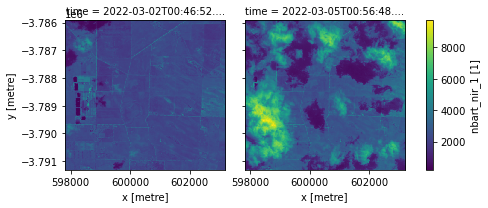

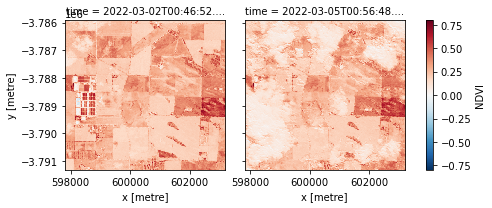

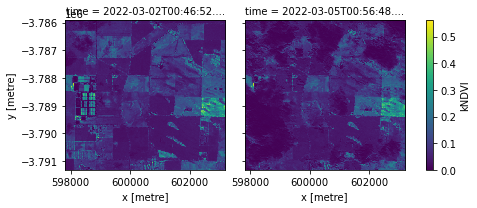

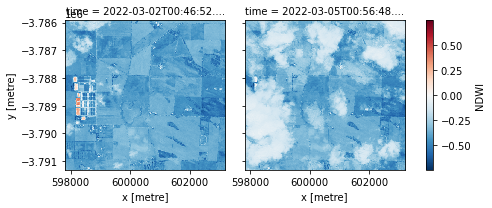

In [8]:
for surveyarea_tile in surveyarea_tiles:
    ds = surveyarea_tile[6] # extract xarray
    
    ds.nbart_nir_1.plot.imshow(col="time")
    ds.NDVI.plot.imshow(col="time")
    ds.kNDVI.plot.imshow(col="time")
    ds.NDWI.plot.imshow(col="time")

## Plot RGB

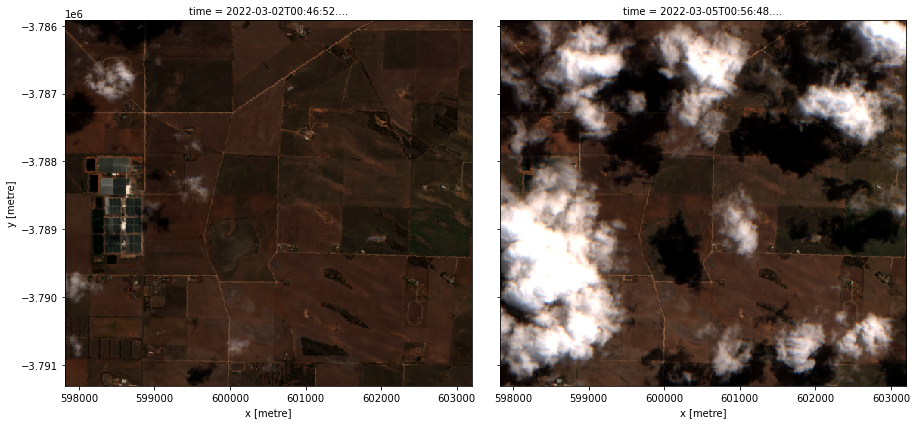

In [9]:
for surveyarea_tile in surveyarea_tiles:
    ds = surveyarea_tile[6] # extract xarray
    rgb(ds, bands=['nbart_red', 'nbart_green', 'nbart_blue'], col="time")